In [1]:
import pyvisa as visa
import numpy as np
import time
import matplotlib.pyplot as plt
#import instrumental
import pandas as pd
import logging 

In [2]:
rm = visa.ResourceManager()
print(rm.list_resources())

('ASRL1::INSTR', 'ASRL2::INSTR', 'ASRL3::INSTR', 'ASRL10::INSTR', 'GPIB0::22::INSTR', 'GPIB0::23::INSTR')


In [3]:
#inicializo los instrumentos 

amperimetro = rm.open_resource('GPIB0::22::INSTR') 
volt = rm.open_resource("GPIB0::23::INSTR") 
pirani = rm.open_resource("ASRL3::INSTR", read_termination='\r')


In [13]:
print(amperimetro.query("MEASURE:VOLTAGE:DC?"))
print(volt.query("MEASURE:VOLTAGE:DC?"))
print((pirani.query("?GA1")))

-1.82100000E-06

+2.42690000E-05

9.91E-02


In [4]:
amperimetro.write('SENS:ZERO:AUTO OFF')
volt.write('SENS:ZERO:AUTO OFF')

amperimetro.write('SENS:VOLT:DC:NPLC 0.02')
volt.write('SENS:VOLT:DC:NPLC 0.02')

# amperimetro.write('CONF:VOLT:DC 100,0.0001') #Seteamos el rango de voltajes que va a medir y los digitos usados - El de arriba ADR 22
volt.write('CONF:VOLT:DC 1,0.00001') #Seteamos el rango de voltajes que va a medir y los digitos usados - El de abajo
amperimetro.write('SENS:VOLT:DC:RANG:AUTO ON')
#volt.write('SENS:VOLT:DC:RANG:AUTO ON')


27

MEDICION SIN PLOT


In [12]:
nro_medicion = 65

V_gen = 1.8 #V
Distancia = 4 #resta[cm]
cant_mediciones = 200
periodo = 30 #s
pendiente_rampa = 50 #%

T = [] #de aca sascamos para el V de la descarga en Volts
V_c = [] #de aca sale para la corriente en Volts
P = []
R2 = 55340
R1 = 67109000 #ohm
R3 = 14800

tiempo_entre_medicion = 0.3 #seg/medicion

mediciones_para_un_periodo_y_medio = periodo//tiempo_entre_medicion #Usamos // para obtener un numero entero de la división


#LOOP DE TOMA DE DATOS
for i in range(cant_mediciones):
    t_0 = time.time()
    #print(f'Medicion numero: {i}')
    t_voltimetro_i = time.time()    #Toma el tiempo para calcular cuánto tarda en medir
    T_i = float(volt.query("READ?")) 
    t_voltimetro_f = time.time()    #La medida al final del voltímetro es la misma que la inicial del amperimetro. Comparten variable
    V_ci = float(amperimetro.query("READ?"))
    t_amperimetro_f = time.time()   #Idem amperimetro
    P_i = float(pirani.query("?GA1"))
    t_pirani_f = time.time()

    P.append(P_i)
    T.append(T_i)
    V_c.append(V_ci)

    I=[]#esta es la del tubo
    for j in range(len(T)):
        I.append(float(V_c[j])/R3)
    I_1=[] 
    for j in range(len(T)):
        I_1.append(float(T[j])/R2)
    V=[]
    for j in range(len(V_c)):
        V.append(float(T[j])-float(V_c[j])+float(I_1[j])*R1)

    t_f = time.time()
    print(f'La medición del voltímetro tardó {t_voltimetro_f-t_voltimetro_i} segundos')
    print(f'La medición del amperímetro tardó {t_amperimetro_f - t_voltimetro_f} segundos')
    print(f'La medición del sensor pirani tardó {t_pirani_f - t_amperimetro_f} segundos')
    print(f'La medición tomo un total de {float(t_f) - float(t_0)} segundos')
    # time.sleep(tiempo_entre_medicion)

#GUARDADO DE DATOS
df = pd.DataFrame()
df["T"] = T #Tension en R2
df['V'] = V #Tension en celda
df["V_c"] = V_c  #Tension en R3
df['I'] = I #Corriente en celda
df["P"] = P
df['V_gen'] = pd.Series(V_gen, index = [0])
df['Distancia'] = pd.Series(Distancia, index = [0])
df['Mediciones p/s'] = pd.Series(tiempo_entre_medicion,index = [0])
df['Fecha'] = pd.Series([time.ctime()],index = [0])
df['Periodo'] = pd.Series(periodo, index = [0])
df['pendiente_rampa'] = pd.Series(pendiente_rampa, index = [0])

df.to_csv(f"C:/Users/publico/Desktop/G6L5V/Clase 18-10/Medición nro {nro_medicion}.csv", encoding = "utf-8")
   
    


La medición del voltímetro tardó 0.016859054565429688 segundos
La medición del amperímetro tardó 0.05031275749206543 segundos
La medición del sensor pirani tardó 0.11854910850524902 segundos
La medición tomo un total de 0.18572092056274414 segundos
La medición del voltímetro tardó 0.01669907569885254 segundos
La medición del amperímetro tardó 0.014581441879272461 segundos
La medición del sensor pirani tardó 0.2840392589569092 segundos
La medición tomo un total de 0.3153197765350342 segundos
La medición del voltímetro tardó 0.016761302947998047 segundos
La medición del amperímetro tardó 0.019461870193481445 segundos
La medición del sensor pirani tardó 0.28306102752685547 segundos
La medición tomo un total de 0.31928420066833496 segundos
La medición del voltímetro tardó 0.016247034072875977 segundos
La medición del amperímetro tardó 0.015845060348510742 segundos
La medición del sensor pirani tardó 0.29230737686157227 segundos
La medición tomo un total de 0.324399471282959 segundos
La med

c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


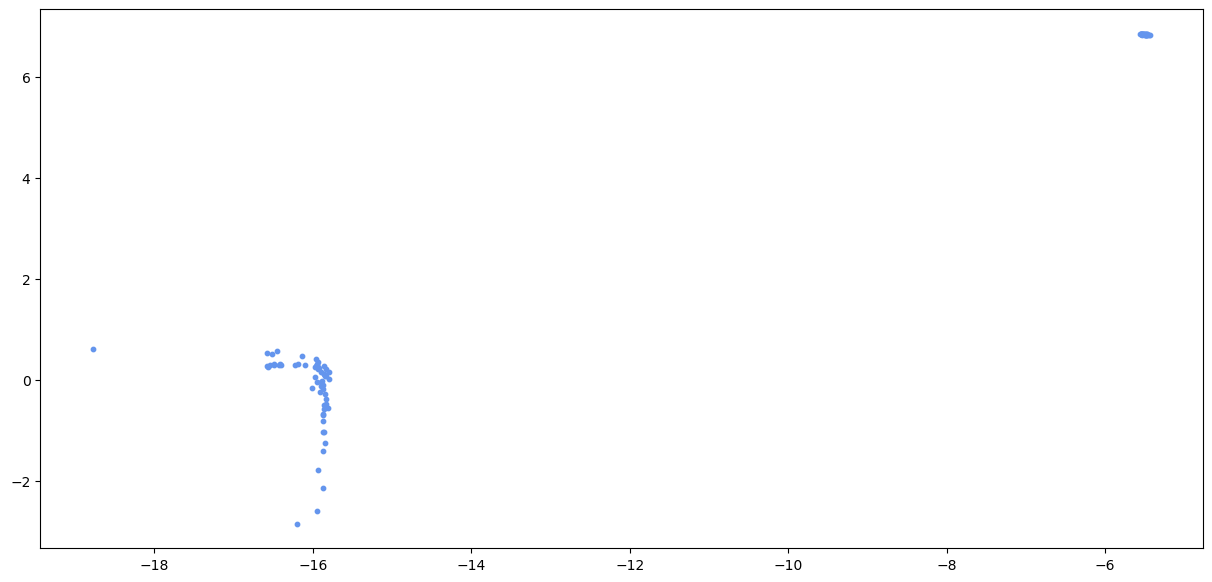

In [13]:
nro_medicion = 65
filename = rf'Clase 18-10\Medición nro {nro_medicion}.csv'
df = pd.read_csv(filename)
I = df['I'] #Corriente en celda
V = df['V'] #Tension en celda
#P = np.mean(df['P'].values)
#d = df['Distancia']
V_max = 460
#pd = P*d

fig,ax = plt.subplots(figsize = (15,7))

ax.scatter(np.log(I),np.log(V),color = 'cornflowerblue', s = 10)
#ax.scatter(pd,V_max)
# ylabels = np.linspace(min(V),max(V),26,endpoint = True)
# ylabels = np.linspace(0,1200,26,endpoint = True)
# ax.text(0.0010,200,f'Voltaje = {V_c} V')
# ax.text(0.001,100,f'Cant de puntos: {cant_mediciones}')
# ax.set_yticks(ylabels)
# ax.set_yticklabels([f'{number:.0f}' for number in ylabels]);

MEDICION CON GRAFICO EN VIVO

In [ ]:
from IPython import display
%matplotlib inline

nro_medicion = 15
T = [] #de aca sascamos para el V de la descarga en Volts
V_c = [] #de aca sale para la corriente en Volts
P = []
R2 = 55340
R1 = 67109000 #ohm
R3 = 14800
periodo = 10 #s
cant_mediciones = 150
tiempo_entre_medicion = 0.3 #seg/medicion
mediciones_para_un_periodo_y_medio = int(periodo//tiempo_entre_medicion)
V_gen = 1.600 #V

yticks = np.arange(0,11,10)*100

# for i in range(mediciones_para_un_periodo_y_medio), Donde 1 y 2 son la inicial y final para el promedio:
for i in range(cant_mediciones):
    print(f'Medicion numero: {i}')
    T_1 = float(volt.query("READ?"))
    V_1 = float(amperimetro.query("READ?"))
    T_2 = float(volt.query("READ?"))
    V_2 = float(amperimetro.query("READ?"))
    T_i = (T_1 + T_2)/2
    V_ci = (V_1 + V_2)/2
    P_i = float(pirani.query("?GA1"))
    P.append(P_i)
    T.append(T_i)
    V_c.append(V_ci)
    #pi.write("!US3")
    #print(pi.query("?GA1"))
    # print("i =", i)
    # print("T =", T_i)
    # print("V_c =", V_ci)
    I=[]#esta es la del tubo
    for j in range(len(T)):
        I.append(float(V_c[j])/R3)
    I_1=[] 
    for j in range(len(T)):
        I_1.append(float(T[j])/R2)
    #I_1=I*R2

    V=[]
    for j in range(len(V_c)):
        V.append(float(T[j])-float(V_c[j])+float(I_1[j])*R1)

    #plt.scatter(I,V)
    plt.xlabel("Corriente Celda")
    plt.ylabel("Tension Celda")
    # plt.yticks(ticks = yticks, labels = yticks)
    plt.scatter(I,V,color = 'cornflowerblue')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.pause(0.1)
   
    time.sleep(tiempo_entre_medicion)

df = pd.DataFrame()
df["T"] = T #Tension en R2
df['V'] = V #Tension en celda
df["V_c"] = V_c  #Tension en R3
df['I'] = I #Corriente en celda
df["P"] = P
df['V_gen'] = pd.Series(V_gen, index = [0])
df['Mediciones p/s'] = pd.Series(tiempo_entre_medicion,index = [0])
df['Fecha'] = pd.Series([time.ctime()],index = [0])
df['Periodo'] = pd.Series(periodo, index = [0])
df['Distancia'] = pd.Series('15.6',index = [0])
df.to_csv(f"C:/Users/publico/Desktop/G6L5V/Clase 18-10/Medición nro {nro_medicion}.csv", encoding = "utf-8")

In [4]:
volt.write('CONF:VOLT:DC 1,0.001')

22

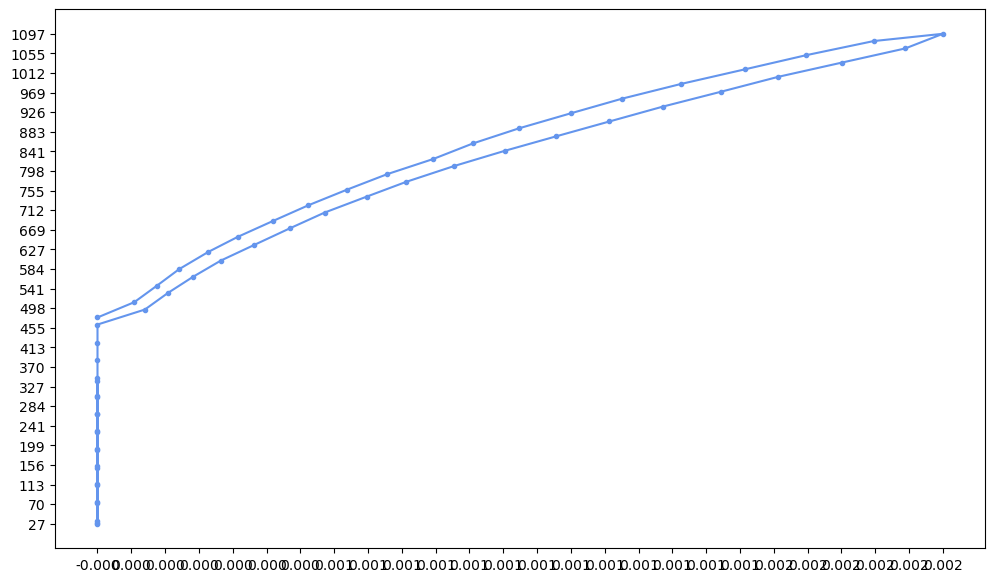

In [80]:
nro_medicion = 500
filename = rf'Clase 18-10\Medición nro 500.csv'
df = pd.read_csv(filename)
I = df['I'] #Corriente en celda
V = df['V'] #Tension en celda

fig,ax = plt.subplots(figsize = (12,7))

ax.plot(I[0:(int(len(I)/2)+30)],V[0:(int(len(I)/2)+30)],color = 'cornflowerblue',marker = '.')
# ax.plot(V,color = 'cornflowerblue')

ylabels = np.linspace(min(V),max(V),26,endpoint = True)
#ax.set_xlim(0.0015,0.0025)
# ylabels = np.linspace(0,1200,26,endpoint = True)
ax.set_yticks(ylabels)
ax.set_yticklabels([f'{number:.0f}' for number in ylabels]);
xlabels = np.linspace(min(I),max(I),26,endpoint = True)
#ax.set_xlim(0.0015,0.0025)
# ylabels = np.linspace(0,1200,26,endpoint = True)
ax.set_xticks(xlabels)
ax.set_xticklabels([f'{number:.3f}' for number in xlabels]);



In [ ]:
for nro_medicion in [1,2,3,4,6,7,8,10,11]:
    filename = rf'Clase 18-10\Medición nro {nro_medicion}.csv'
    df = pd.read_csv(filename)
    I = df['I'] #Corriente en celda
    V = df['V'] #Tension en celda

    fig,ax = plt.subplots()

    ax.scatter(I,V,color = 'cornflowerblue')
    ylabels = np.linspace(min(V),max(V),26,endpoint = True)
    #ax.set_xlim(0.0015,0.0025)
    # ylabels = np.linspace(0,1200,26,endpoint = True)
    ax.set_yticks(ylabels)
    ax.set_yticklabels([f'{number:.0f}' for number in ylabels]);


<class 'float'>
[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 482.0, 78.8, 25.7, 11.7, 5.96, 3.31, 2.07, 1.3, 0.911, 0.648, 0.503, 0.401, 0.343, 0.288, 0.262, 0.239, 0.223, 0.212, 0.202, 0.194, 0.187, 0.181, 0.177, 0.173, 0.17, 0.166, 0.164, 0.162, 0.16, 0.158, 0.156, 0.154, 0.152, 0.151, 0.15, 0.149, 0.147, 0.145, 0.144, 0.143, 0.142, 0.14, 0.139, 0.139, 0.137]


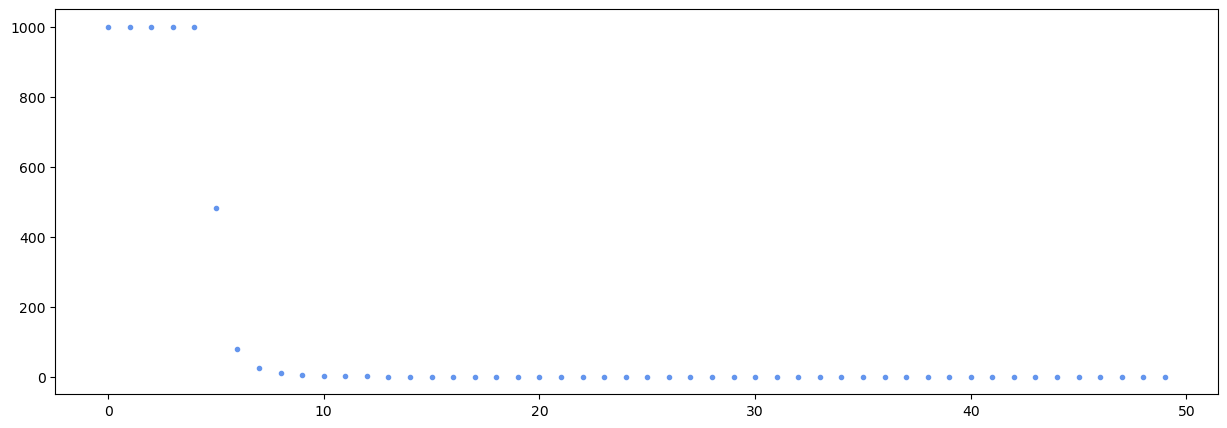

In [71]:
print(type(presion[0]))
print(presion)
fig,ax = plt.subplots(figsize = (15,5))
ax.scatter(np.arange(len(presion)),presion, color = 'cornflowerblue',marker = '.')

In [30]:
print(pirani.write('*IDN?'))
print(pirani.query("?GA2"))

7
1.00E+03


In [12]:
T_i = float(volt.query("MEASURE:VOLTAGE:DC?"))
V_ci = float(amperimetro.query("MEASURE:VOLTAGE:DC?"))